In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-reviewss/fake_review.csv


In [2]:
!pip install datasets evaluate
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import DataCollatorWithPadding

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [3]:
dataset_dict = load_dataset('csv', data_files='/kaggle/input/fake-reviewss/fake_review.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
tokenizer_name = "FacebookAI/roberta-base"
model_name = "FacebookAI/roberta-base"
id2label = {0: "FAKE", 1: "REAL"}
label2id = {"FAKE": 0, "REAL": 1}

In [18]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2label, label2id=label2id)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
dataset_dict = dataset_dict["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_dict["train"]
test_dataset = dataset_dict["test"]

In [20]:
train_dataset = train_dataset.filter(lambda x: x['text'] is not None)
test_dataset =  test_dataset.filter(lambda x: x['text'] is not None)

Filter:   0%|          | 0/2560 [00:00<?, ? examples/s]

Filter:   0%|          | 0/640 [00:00<?, ? examples/s]

In [21]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

In [22]:
encoded_train_dataset = train_dataset.map(tokenize_function, batched=True)
encoded_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2560 [00:00<?, ? examples/s]

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

In [23]:
encoded_train_dataset = encoded_train_dataset.rename_column("label", "labels")
encoded_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

encoded_test_dataset = encoded_test_dataset.rename_column("label", "labels")
encoded_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [24]:
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
!pip install torch
import torch

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [26]:
import os
os.environ["WANDB_MODE"] = "disabled"
import wandb
wandb.init(mode="disabled")

In [27]:
# prompt: generate compute metrics for the collab model using classification report

import numpy as np
from sklearn.metrics import classification_report

# Define the metric
metric = evaluate.load("accuracy")

# Define a function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.613161,0.693750
2,No log,0.304081,0.879687
3,No log,0.384766,0.893750
4,0.322600,0.480044,0.896875
5,0.322600,0.639365,0.878125


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=800, training_loss=0.23660415172576904, metrics={'train_runtime': 788.502, 'train_samples_per_second': 16.233, 'train_steps_per_second': 1.015, 'total_flos': 3367821508608000.0, 'train_loss': 0.23660415172576904, 'epoch': 5.0})

In [29]:

# Make predictions on the test set
predictions = trainer.predict(encoded_test_dataset)

# Get predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Get true labels
true_labels = predictions.label_ids

# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=['FAKE', 'REAL']))

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

        FAKE       0.85      0.94      0.89       336
        REAL       0.93      0.81      0.86       304

    accuracy                           0.88       640
   macro avg       0.89      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640



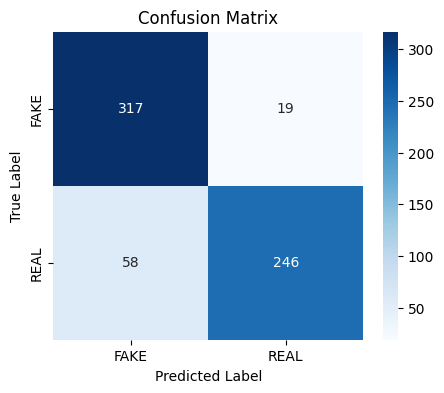

In [30]:
# prompt: generate confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# import wandb
# wandb.login(key="b7459d2d1cad50b1b2f3388aa0792a3495511f1d")